In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
from datetime import datetime
import json
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from collections import defaultdict

pd.set_option('display.max_columns', None)

In [2]:
data = None
with open('./IntermediateData/zanek_initial_results.json', 'r') as json_file:
    data = json.load(json_file)

In [3]:
def parse_date(date_str):
    return datetime.strptime(date_str, '%m/%d/%Y')

# sort dict by date
data = {key: data[key] for key in sorted(data, key=parse_date)}

# Analysis Bits:

1. Winrate percentage 
2. Time of trades exited 
4. Running PnL graph 
5. Avg & Median win/loss
6. Wins by month and years

In [4]:
#first create a function to return data for analysis paramterized on what years we want to show

In [5]:
#array of years in strings 
def granulize(years):
    #new data dict to return
    filtered_data = {}
    if years[0] == 'all':
        for key, value in data.items():
            if value == None:
                continue
            filtered_data[key] = value
    else:
        for year in years:
            #loop through years in the array of years we want 
            for key, value in data.items():
                if value == None:
                    continue
                #if the key date contains the year, then we want that data, so we add it to the new dict
                if year in key:
                    filtered_data[key] = value
        
    return filtered_data

# Change or add years to the list to get years to analyze data

In [6]:
years = ['all']

In [7]:
filtered_data = granulize(years)

In [8]:
print(filtered_data)

{'10/18/2021': [{'Location': 15060.0, 'Direction': 'Short', 'RR': 33.0, 'entry_time': '09:35:00'}, '09:40:00', False], '10/19/2021': [{'Location': 15337.25, 'Direction': 'Long', 'RR': 32.5, 'entry_time': '09:35:00'}, '10:55:00', True], '10/20/2021': [{'Location': 15408.25, 'Direction': 'Short', 'RR': 21.5, 'entry_time': '09:35:00'}, '09:40:00', False], '10/21/2021': [{'Location': 15366.5, 'Direction': 'Long', 'RR': 32.75, 'entry_time': '09:35:00'}, '10:05:00', True], '10/22/2021': [{'Location': 15437.75, 'Direction': 'Long', 'RR': 33.5, 'entry_time': '09:35:00'}, '09:45:00', False], '10/25/2021': [{'Location': 15393.0, 'Direction': 'Short', 'RR': 41.25, 'entry_time': '09:35:00'}, '09:40:00', True], '10/26/2021': [{'Location': 15632.5, 'Direction': 'Long', 'RR': 52.75, 'entry_time': '09:35:00'}, '10:15:00', True], '10/27/2021': [{'Location': 15566.0, 'Direction': 'Short', 'RR': 35.75, 'entry_time': '09:35:00'}, '09:40:00', False], '10/28/2021': [{'Location': 15653.75, 'Direction': 'Shor

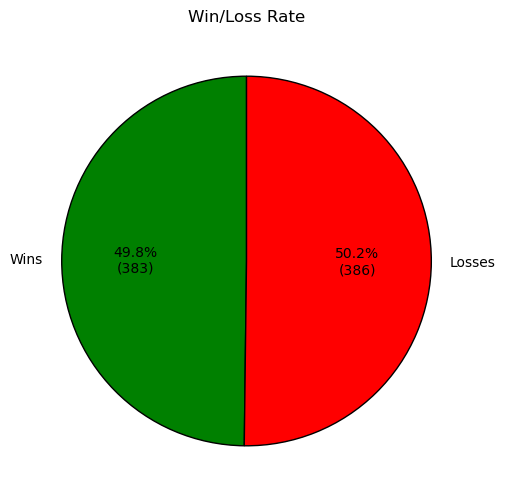

In [9]:
def getWinRate(data):
    win_count = 0
    loss_count = 0
    
    for key, value in data.items():
        if value[2]: 
            win_count += 1
        else:
            loss_count += 1
    
    return win_count, loss_count

# get counts for win and loss
win_count, loss_count = getWinRate(filtered_data)

# data for pie
labels = ['Wins', 'Losses']
sizes = [win_count, loss_count]

# function displays raw and pct
def autopct_with_count(pct, sizes):
    total = sum(sizes)
    # calculate the count based on the percentage
    count = int(round(pct * total / 100.0))  
    # return formatted string with percentage and count
    return f'{pct:.1f}%\n({count})'  

# plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct=lambda pct: autopct_with_count(pct, sizes),
        startangle=90, colors=['green', 'red'], wedgeprops={'edgecolor': 'black'})

plt.title('Win/Loss Rate')

plt.show()


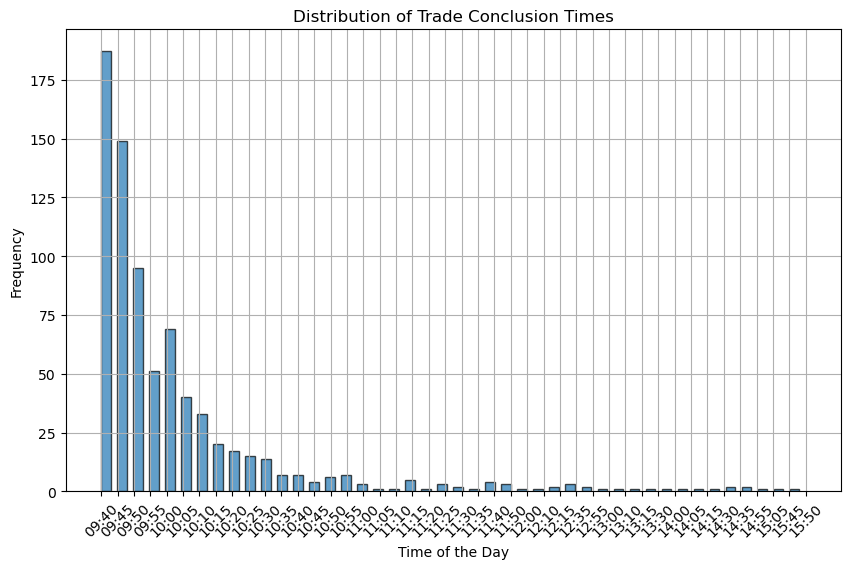

In [10]:
def getTradeTimes(data):
    # extract the times of trade conclusions (value[2] contains the time)
    trade_times = []
    for key, value in data.items():
        trade_time = value[1]  # Get time from the 3rd element of the tuple
        trade_times.append(trade_time)
    return trade_times

trade_times = getTradeTimes(filtered_data)

# convert the time strings to datetime objects
time_series = pd.to_datetime(trade_times, format='%H:%M:%S')

# extract the hour and minute as a string for plotting
time_strings = time_series.strftime('%H:%M')

# sort time strings in chronological order
sorted_time_strings = sorted(time_strings, key=lambda x: pd.to_datetime(x, format='%H:%M'))

# plotting the histogram of trade conclusion times
plt.figure(figsize=(10, 6))

# create histogram using the sorted time strings as bins
plt.hist(sorted_time_strings, bins=len(set(sorted_time_strings)), edgecolor='black', alpha=0.7, width=0.6)

# label the chart
plt.title('Distribution of Trade Conclusion Times')
plt.xlabel('Time of the Day')
plt.ylabel('Frequency')

# Sort the x-axis labels to show time in correct order
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

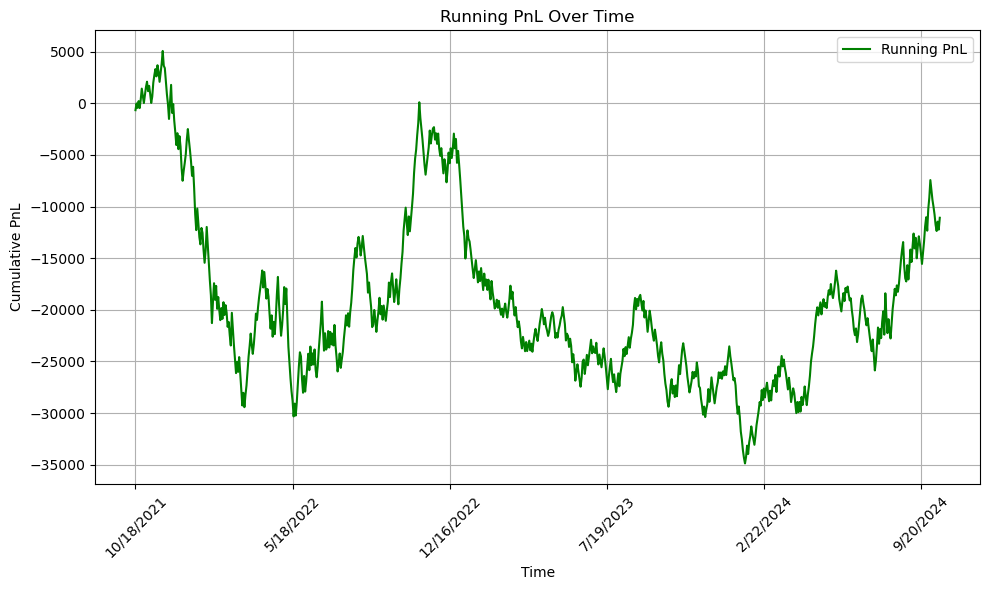

In [11]:
def getPnL(data):

    pnl_values = []

    #if true in index 2, meaning trade won, we multiply by 20, since that is the point -> $ conversion for NQ
    for key, value in data.items():
        if value[2]:
            pnl_values.append(value[0].get('RR', 0) * 20) 
        else:
            pnl_values.append(value[0].get('RR', 0) * -20)  

    return pnl_values

def plot_running_pnl(pnl_values, times):
    
    # calculate the cumulative sum of PnL values
    cumulative_pnl = pd.Series(pnl_values).cumsum()

    # create a plot of the running PnL
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(times, cumulative_pnl, label="Running PnL", color='green')

    ax.set_title('Running PnL Over Time')
    ax.set_xlabel('Time')
    ax.set_ylabel('Cumulative PnL')


    plt.xticks(rotation=45)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    
pnl_values = getPnL(filtered_data)

# get the times of trade conclusions 
times = list(filtered_data.keys())

# plot the running PnL
plot_running_pnl(pnl_values, times)


In [12]:
def calculate_avg_and_median(data):
    # Separate wins and losses based on the last item in the tuple (True for win, False for loss)
    wins = []
    losses = []
    
    for key, value in data.items():
        pnl = value[0].get('RR', 0)
        is_win = value[2]  
        
        if is_win:
            wins.append(pnl)
        else:
            losses.append(pnl)
    
    # convert lists to pandas series to easily calculate stats
    wins_series = pd.Series(wins)
    losses_series = pd.Series(losses)
    
    # calculate average and median for wins and losses
    avg_win = wins_series.mean() if len(wins) > 0 else 0
    median_win = wins_series.median() if len(wins) > 0 else 0
    avg_loss = losses_series.mean() if len(losses) > 0 else 0
    median_loss = losses_series.median() if len(losses) > 0 else 0
    
    return {
        "avg_win": avg_win,
        "median_win": median_win,
        "avg_loss": avg_loss,
        "median_loss": median_loss
    }

stats = calculate_avg_and_median(filtered_data)

print("Average and Median of Wins and Losses:")
print(f"Avg Win: {stats['avg_win']}, Median Win: {stats['median_win']}")
print(f"Avg Loss: {stats['avg_loss']}, Median Loss: {stats['median_loss']}")


Average and Median of Wins and Losses:
Avg Win: 52.58355091383812, Median Win: 49.25
Avg Loss: 53.61010362694301, Median Loss: 49.375


<Figure size 1200x600 with 0 Axes>

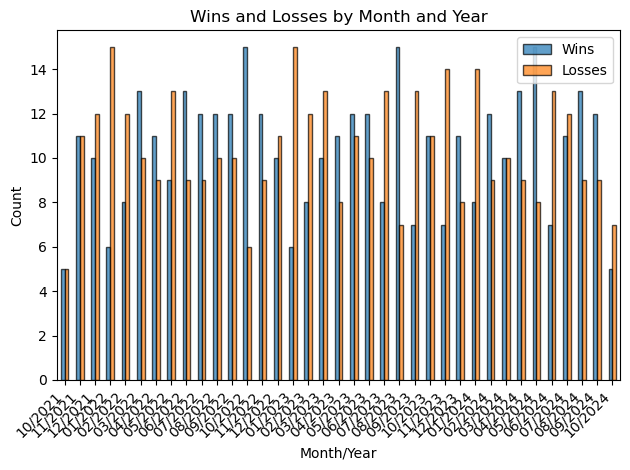

In [13]:


def calculate_wins_and_losses_by_month(data):
    # dictionary to store wins and losses by month and year
    monthly_wins_losses = defaultdict(lambda: {"wins": 0, "losses": 0})
    
    # iterate over the trades
    for key, value in data.items():
        trade_date = pd.to_datetime(key, format='%m/%d/%Y')
        pnl = value[0].get('RR', 0)  
        is_win = value[2]  
        
        # create a string to group dates
        month_year = trade_date.strftime('%m/%Y')
        
        if is_win:
            monthly_wins_losses[month_year]["wins"] += 1
        else:
            monthly_wins_losses[month_year]["losses"] += 1
    
    return monthly_wins_losses

# calculate wins and losses by month and year
monthly_wins_losses = calculate_wins_and_losses_by_month(filtered_data)

# convert to a DataFrame for easier plotting
df = pd.DataFrame.from_dict(monthly_wins_losses, orient='index')

# plotting the wins and losses by month and year
plt.figure(figsize=(12, 6))
df.plot(kind='bar', stacked=False, edgecolor='black', alpha=0.7)

plt.title('Wins and Losses by Month and Year')
plt.xlabel('Month/Year')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(['Wins', 'Losses'])
plt.tight_layout()

plt.show()


In [14]:
filtered_data['1/10/2022']

[{'Location': 15311.0,
  'Direction': 'Short',
  'RR': 104.25,
  'entry_time': '09:35:00'},
 '10:10:00',
 True]

In [15]:
# Will prepare to export this into a csv for a power bi analysis



filtered_data_to_list = []

for key, value in filtered_data.items():
    temp_dict = {}
    temp_dict['date'] = key
    temp_dict['entry'] = value[0]['Location']
    temp_dict['direction'] = value[0]['Direction']
    temp_dict['rr'] = value[0]['RR']
    temp_dict['time_entry'] = value[0]['entry_time']
    temp_dict['time_exit'] = value[1]
    temp_dict['win'] = value[2]

    filtered_data_to_list.append(temp_dict)

data_export = pd.DataFrame(filtered_data_to_list)
data_export.head()

,date,entry,direction,rr,time_entry,time_exit,win
0,10/18/2021,15060.00,Short,33.00,09:35:00,09:40:00,False
1,10/19/2021,15337.25,Long,32.50,09:35:00,10:55:00,True
2,10/20/2021,15408.25,Short,21.50,09:35:00,09:40:00,False
3,10/21/2021,15366.50,Long,32.75,09:35:00,10:05:00,True
4,10/22/2021,15437.75,Long,33.50,09:35:00,09:45:00,False


In [16]:
data_export.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        769 non-null    object 
 1   entry       769 non-null    float64
 2   direction   769 non-null    object 
 3   rr          769 non-null    float64
 4   time_entry  769 non-null    object 
 5   time_exit   769 non-null    object 
 6   win         769 non-null    bool   
dtypes: bool(1), float64(2), object(4)
memory usage: 36.9+ KB


In [17]:
#data_export.to_csv('./IntermediateData/zanek_wrangled_results.csv')

In [18]:
data_export.describe()

,entry,rr
count,769.000000,769.000000
mean,15095.201235,53.098830
std,2724.279097,22.334781
min,10541.750000,5.000000
25%,12641.500000,38.000000
50%,15063.750000,49.250000
75%,17201.000000,65.500000
max,20868.000000,200.250000


In [21]:
def find_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)  
    Q3 = df[col].quantile(0.75) 
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

outliers = find_outliers_iqr(data_export, 'rr')
print(outliers)
print(outliers['rr'].min())
print(len(outliers))

           date     entry direction      rr time_entry time_exit    win
35    12/6/2021  15625.00     Short  135.75   09:35:00  10:15:00  False
57     1/6/2022  15797.50      Long  125.75   09:35:00  10:00:00  False
68    1/21/2022  14706.50     Short  112.25   09:40:00  10:10:00   True
73    1/28/2022  13967.75     Short  134.75   09:35:00  10:50:00  False
78     2/4/2022  14454.75     Short  111.00   09:35:00  09:40:00  False
92    2/24/2022  13216.00      Long  158.25   09:35:00  10:10:00   True
135   4/27/2022  13118.50      Long  108.75   09:35:00  09:45:00   True
137   4/29/2022  13353.75      Long  127.25   09:35:00  10:25:00  False
142    5/6/2022  12682.25     Short  110.75   09:35:00  09:45:00   True
145   5/11/2022  12181.25     Short  139.50   09:35:00  09:40:00  False
146   5/12/2022  11732.75     Short  142.50   09:35:00  09:45:00  False
159   5/31/2022  12579.75     Short  108.50   09:35:00  11:50:00  False
167   6/10/2022  11976.00     Short  114.25   09:35:00  10:20:00